# Reading BODC data. Writing NC files with temperature along each mooring


** Summary: **
BODC data are provided as one file per instrument, i.e. per depth. This script reads all the netcdf files in a directory, extract the data per mooring, and then write a netcdf file with hourly temperature for each mooring.

** Problems/To do **
* Read models data and interpolate them on the same grid (time/depth)

** Notebook: ** BODC_data_writenc_mooring.ipynb

** Author: ** kariho40 27 dec 2015

** Changelog: **
* 20 Dec 2015 (jelt): get started from jelt script peanom.ipynb
* 27 Dec 2015 (kariho40): create a 2D array of temperature for each station, and interpolate on an hourly frequency


In [18]:
## Import the libraries

import numpy as np
import numpy.ma as ma
from scipy.io import netcdf
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt  # plotting
from sympy import * 
from __future__ import division

init_printing()  # for sympy
%matplotlib inline

## Personal librairies
import bodc_data_tools

######### Personal Paths #############
HOME = '/media/karen/data1/AMM60/OBS/' #/home/karen/AMM60/'
CRUISE_DIR = HOME + 'JC088/'
CSV_FILENAME = 'bodc_series_metadata_summary.csv'
WRITEDIR = '/media/karen/data1/AMM60/FASTNEt/BODC_fastnet/'


### Read the bodc data.

It needs the path to the csv file in entry (so we can use the same script for D376 and JC88)

In [19]:
csv_content=bodc_data_tools.readBodcCSV(CRUISE_DIR + CSV_FILENAME)
print 'There are',len(csv_content), 'instruments with reference numbers \n'

There are 68 instruments with reference numbers 



### For a unique lon/lat pair extract the depths and BODC references


In [22]:
# extract depth and BODC file names from the csv file, for a unique lon/lat pair
moorings = {}
for row in csv_content:
    loc = row['Latitude A'] + ',' + row['Longitude A']
    if moorings.has_key(loc):
        moorings[loc].append(row)
    else:
        moorings[loc] = [row]
        
print(moorings.keys())
for key in moorings:
    print('at ' + key + ' there are ' + str(len(moorings[key])) +' measurements')

# Check that the instruments are at fixed depths. Check that the max and min depths are equal for each instrument
for row in csv_content:
    if row['Series depth maximum (m)'] != row['Series depth minimum (m)']:
        print 'instruments are not all stationary. Depth variables need attention.'
        stop
print 'instruments are all stationary in depth. Depth variables will be OK'



['55.8994,-9.28556', '55.9028,-9.3088', '55.42965,-9.98928', '55.3984,-9.9893', '55.4269,-9.9888', '55.42965,-9.9893', '55.39838,-9.91445', '55.87375,-9.05853', '55.5454,-9.5462', '55.54542,-9.5462']
at 55.8994,-9.28556 there are 4 measurements
at 55.9028,-9.3088 there are 1 measurements
at 55.42965,-9.98928 there are 9 measurements
at 55.3984,-9.9893 there are 1 measurements
at 55.4269,-9.9888 there are 1 measurements
at 55.42965,-9.9893 there are 4 measurements
at 55.39838,-9.91445 there are 13 measurements
at 55.87375,-9.05853 there are 30 measurements
at 55.5454,-9.5462 there are 2 measurements
at 55.54542,-9.5462 there are 3 measurements
instruments are all stationary in depth. Depth variables will be OK


Coordinates of the moorings:
('-9.28556', '55.8994')
('-9.3088', '55.9028')
('-9.98928', '55.42965')
('-9.9893', '55.3984')
('-9.9888', '55.4269')
('-9.9893', '55.42965')
('-9.91445', '55.39838')
('-9.05853', '55.87375')
('-9.5462', '55.5454')
('-9.5462', '55.54542')


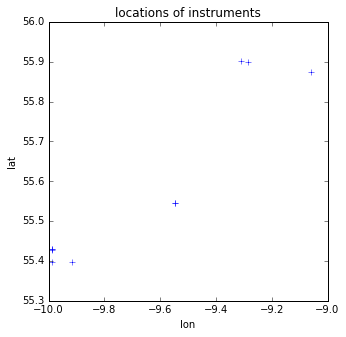

In [23]:
# Plot the locations of these data
fig, ax = plt.subplots(1,1)
plt.rcParams['figure.figsize'] = (5.0, 5.0)

print('Coordinates of the moorings:')
for key in moorings:
    row = moorings[key][0]
    print(row['Longitude A'], row['Latitude A'])
    plt.plot(row['Longitude A'], row['Latitude A'],'b+')

    
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('locations of instruments')

plt.show()

Coordinates of the moorings:
SC2 ('-9.28556', '55.8994')
SC1 ('-9.3088', '55.9028')
LA ('-9.98928', '55.42965')
 ('-9.9893', '55.3984')
('-9.9888', '55.4269')
('-9.9893', '55.42965')
LB ('-9.91445', '55.39838')
SE ('-9.05853', '55.87375')
SB ('-9.5462', '55.5454')
('-9.5462', '55.54542')



### Data interpolation along a mooring line 


This bit loops on each mooring location, and:

* extracts temperature time and depth from all the moorings at this location

* orders them by depth

* masks the outliers and/or missing data

* Interpolates them on an hourly (or 'freq') axis

* writes a netcdf file per mooring containing the temperature function fo depth and time


55.8994,-9.28556
there are 4 instruments along this mooring
Interpolation on 16 days, i.e. 384 points
55.9028,-9.3088
there are 1 instruments along this mooring
Not enough data on the vertical, profile removed
1
55.42965,-9.98928
there are 9 instruments along this mooring
Interpolation on 16 days, i.e. 384 points
55.3984,-9.9893
there are 1 instruments along this mooring
Not enough data on the vertical, profile removed
1
55.4269,-9.9888
there are 1 instruments along this mooring
Not enough data on the vertical, profile removed
1
55.42965,-9.9893
there are 4 instruments along this mooring
Interpolation on 16 days, i.e. 384 points
55.39838,-9.91445
there are 13 instruments along this mooring
Interpolation on 16 days, i.e. 384 points
55.87375,-9.05853
there are 30 instruments along this mooring
Interpolation on 16 days, i.e. 384 points
55.5454,-9.5462
there are 2 instruments along this mooring
Not enough data on the vertical, profile removed
2
55.54542,-9.5462
there are 3 instruments alon

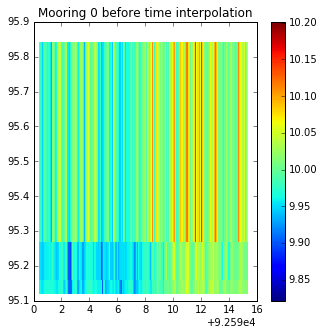

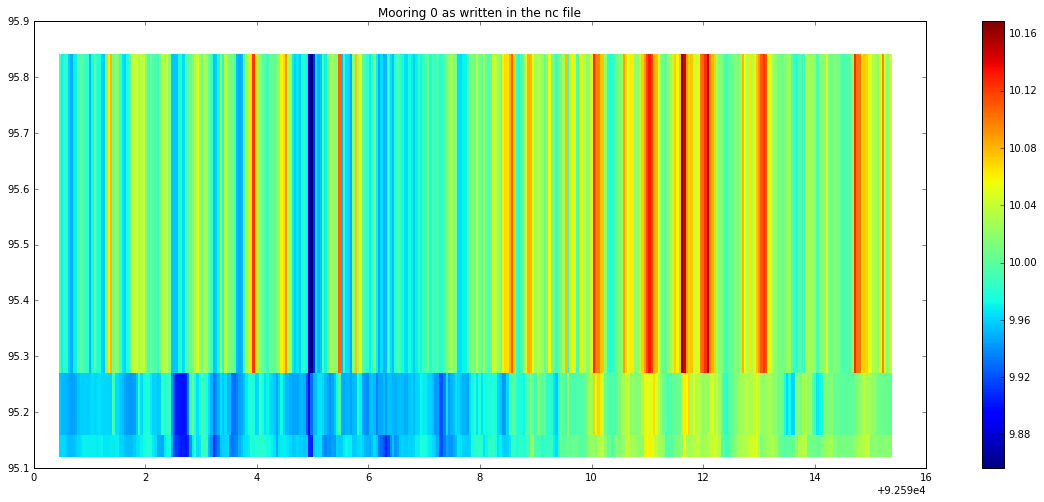

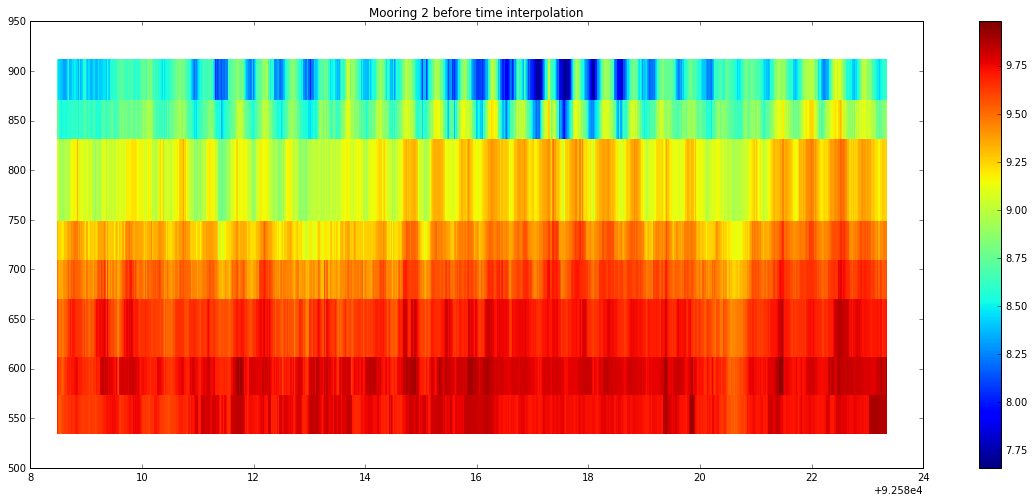

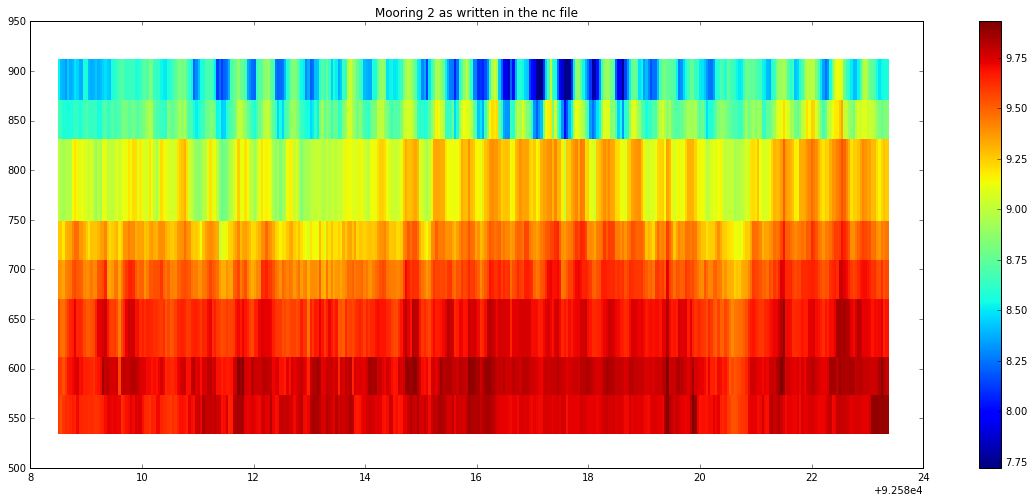

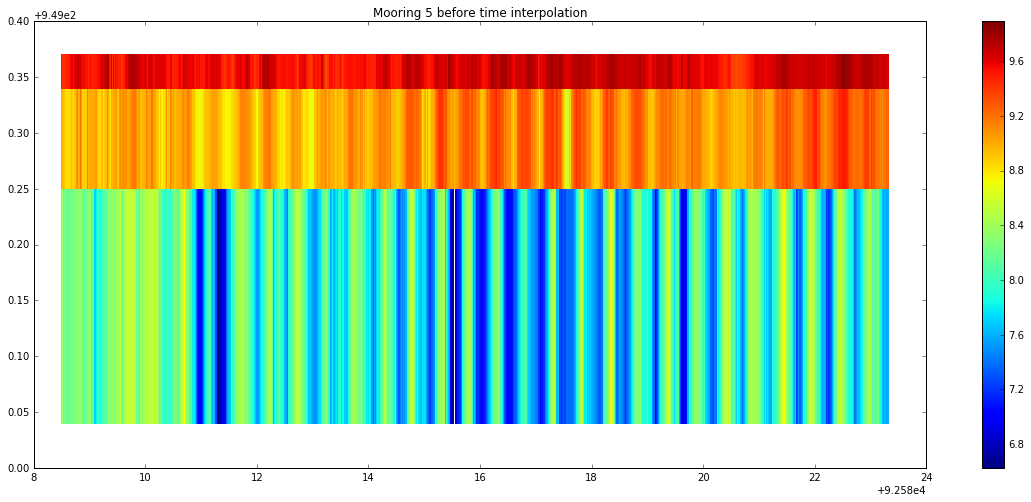

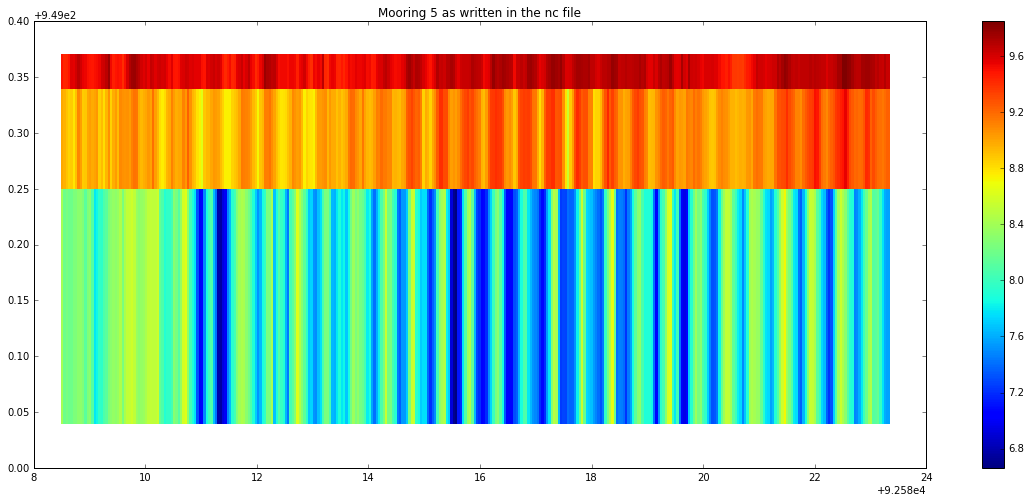

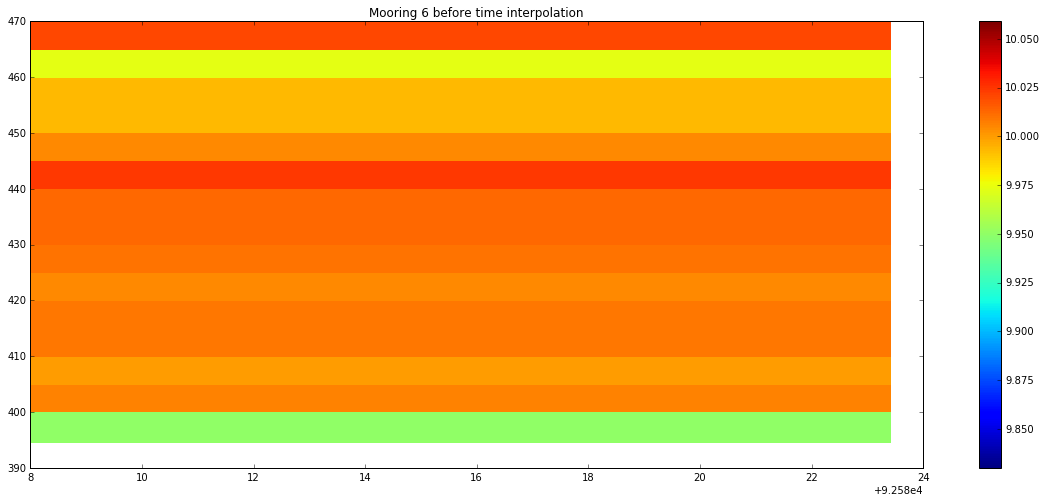

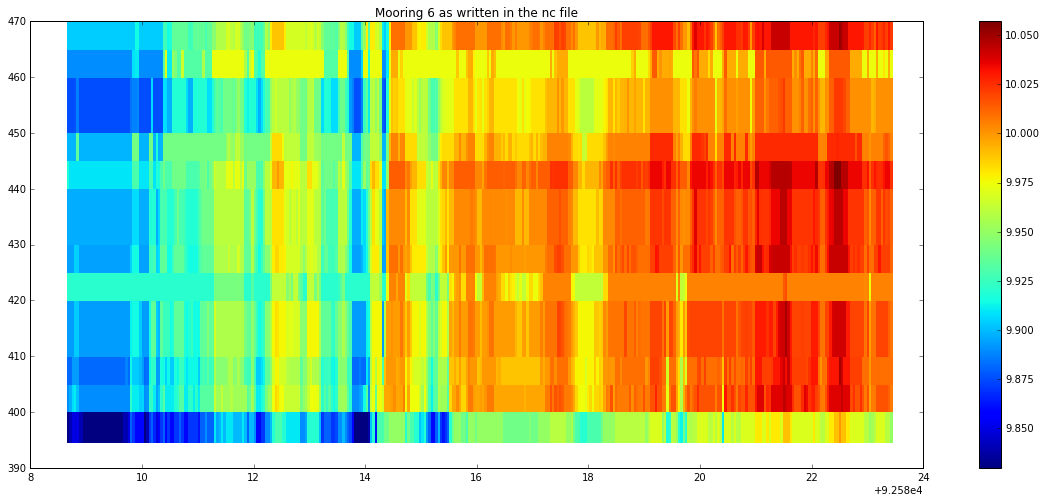

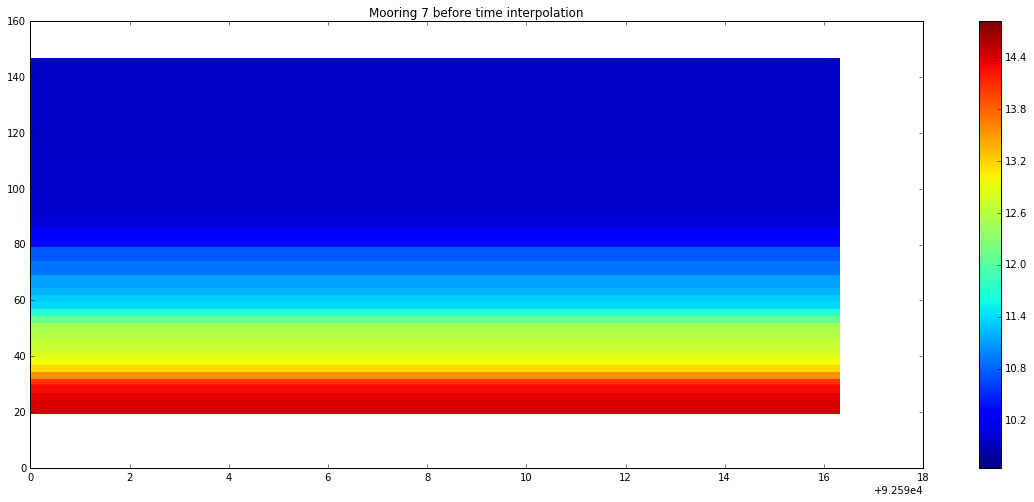

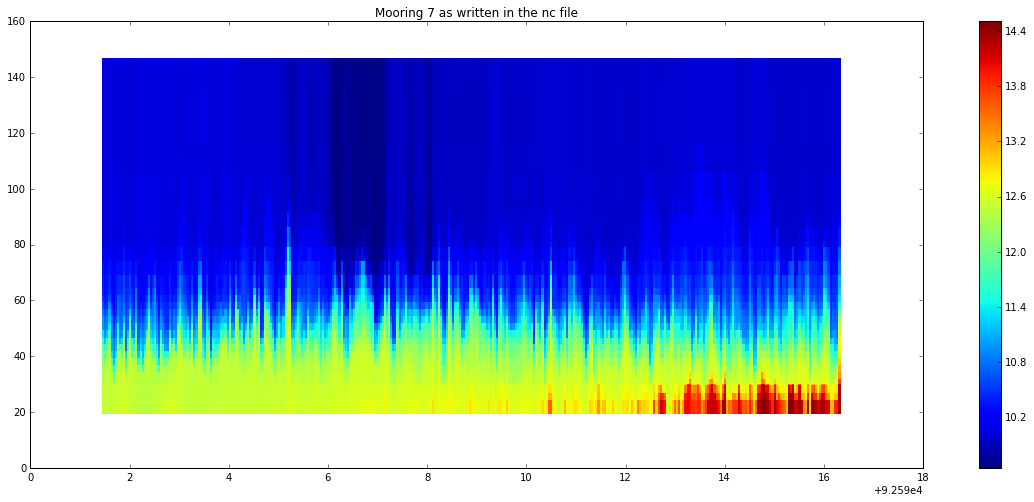

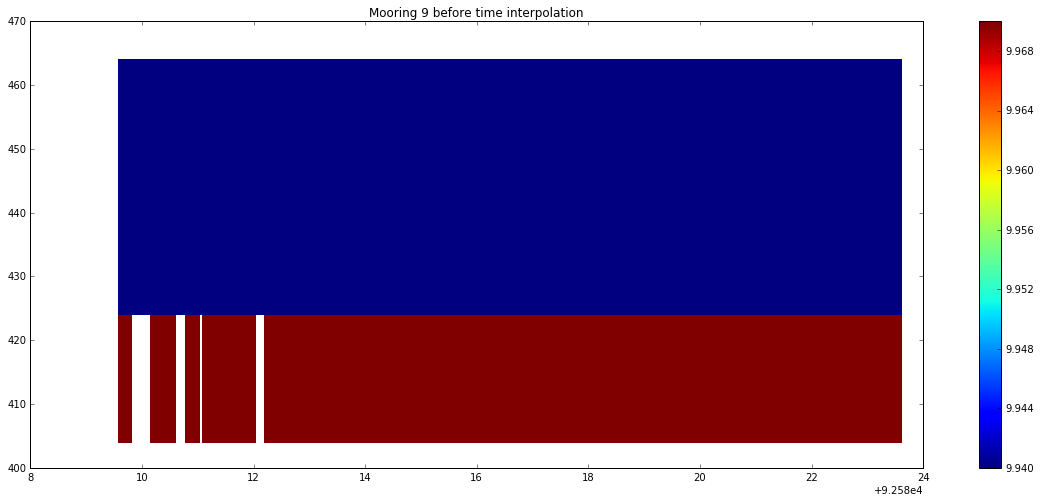

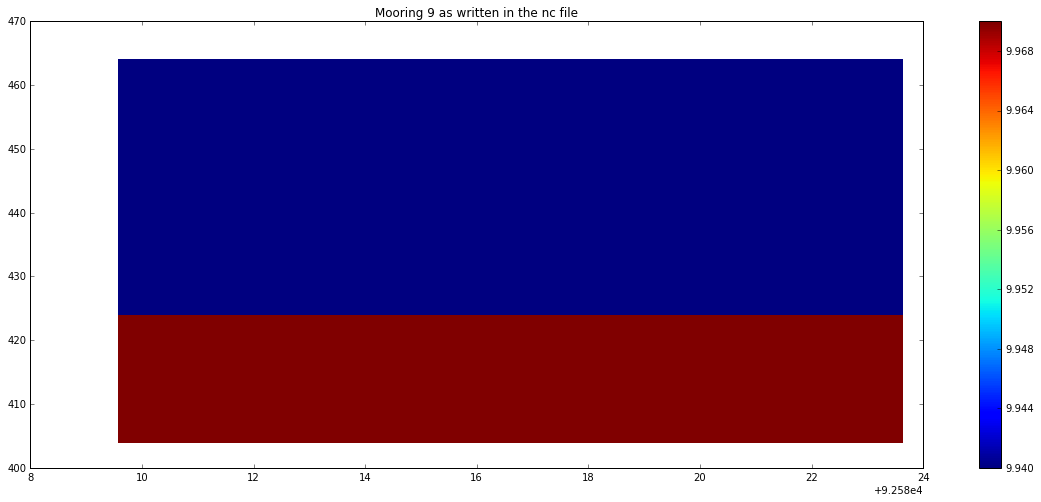

In [24]:
for location in range(len(moorings.values())):
    mooring = moorings.values()[location]
    coord = moorings.keys()[location]
    print(coord)
    [lat,lon] = coord.split(',')
    print('there are {} instruments along this mooring'.format(len(mooring)))
    if int(format(len(mooring))) <= 2:
        print('Not enough data on the vertical, profile removed')
        print(format(len(mooring)))
        continue
    # For each mooring, extract temperature, depth and time from the BODC files
    temperature, time, depth = bodc_data_tools.readBodcDataGivenLoc(mooring, CRUISE_DIR)
    
    # Plot the temperature time series. Beware, time axis is not the same for all instruments !
    fig, ax = plt.subplots(1,1)
    plt.rcParams['figure.figsize'] = (20.0, 8.0)
    plt.pcolormesh(time[0,:],depth[:],temperature)
    plt.colorbar()
    plt.title('Mooring ' + str(location) + ' before time interpolation')
    # Time-interpolation of the data (each instrument has its own frequency)
    # Freq = Time frequency for timeseries interpolation (1h for AMM60 comp)
    freq = 24
    temperature_taxis, taxis = bodc_data_tools.readBodcInterpTime(temperature,time,freq)
    fig, ax = plt.subplots(1,1)
    plt.rcParams['figure.figsize'] = (20.0, 8.0)
    plt.pcolormesh(taxis,depth,temperature_taxis)
    plt.colorbar()
    plt.title('Mooring '+ str(location)+' as written in the nc file')
    
    # Write NC
    ncname = WRITEDIR + 'malin_' + str(location) + '.nc'
    bodc_data_tools.readBodcWriteNC(ncname,temperature_taxis,taxis,depth,lon,lat)


In [ ]:
print(type(lon))
print(lon)
toto=float(lon)
print(type(toto))